# PROBLEM SET 4: 
# NEURAL NETWORKS PART TWO

<br>
<br>
<br>

# PROBLEM 1 (40%)

In the lecture notebook we discussed how a neural network autoencoder trained with respect to the mean squared error objective function and no non-linearity can reproduce PCA. In this problem we want to show this explicitly. First, take the 0 and 1 digits from the sklearn digits dataset. 

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

from sklearn.datasets import load_digits
digits = load_digits()
selector = digits.target < 2
X = digits.data[selector]
#Taking the 0 and 1 digits from sklearn digits dataset 
Y = digits.target[selector]

/Users/arp504/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Next, apply PCA to the dataset (ignoring the digit labels) and plot the resulting dimensional reduction down to $d=2$ (i.e. the projection onto the two leading principal components). Label each datapoint according to its digit label (e.g. red and blue). So far this is just reproducing what we've already done in the lecture notebook. But now we want to reproduce the same plot (or at least a very similar plot) using a neural network autoencoder. To do this you should do the following steps:

- use the FunctionApproximator class to train a neural network with the output vectors ($y_i$) equal to the correspoding input vectors ($x_i$), i.e. $y_i = x_i$ for all $i$ 

- use only two hidden units (this way we'll only get the two leading principal components) and set the activation function (i.e. the non-linearity) to none ('activation=None' as an argument to FunctionApproximator); note that the cost function is the mean squared error by default so we don't need to specify that explicitly

- use the get_y_pred() function in FunctionApproximator to get the vectors outputted by the neural network on the input vectors; note that although these predicted vectors are 64 dimensional they all in fact live in a 2-dimensional subspace, since they all had to pass through the 2 hidden units

In [2]:
from function_approximator2 import FunctionApproximator

In [3]:
n,N = X.shape
fa = FunctionApproximator(n_in=N, n_out=N, n_hidden=2, activation=None)
fa.train(X, X, learning_rate=0.01, n_epochs=400000, report_frequency=20000)
Y_pred = fa.get_y_pred()

epoch: 20000  cost: 9.045547
epoch: 40000  cost: 8.969048
epoch: 60000  cost: 8.884371
epoch: 80000  cost: 8.790718
epoch: 100000  cost: 8.687000
epoch: 120000  cost: 8.571768
epoch: 140000  cost: 8.443471
epoch: 160000  cost: 8.300937
epoch: 180000  cost: 8.146903
epoch: 200000  cost: 7.992107
epoch: 220000  cost: 7.833850
epoch: 240000  cost: 7.686101
epoch: 260000  cost: 7.556707
epoch: 280000  cost: 7.449911
epoch: 300000  cost: 7.365940
epoch: 320000  cost: 7.302145
epoch: 340000  cost: 7.254590
epoch: 360000  cost: 7.219300
epoch: 380000  cost: 7.192903
epoch: 400000  cost: 7.172819


- run PCA on these predicted output vectors and plot the transformed dataset by projecting onto the two leading principal components (basically this will just find the relevant two-dimensional subspace within the set of output vectors; the 'actual' PCA was done by the autoencoder it's just that we use the PCA class to easily identify the subspace that the autoencoder has chosen)

- plot the 'classical' PCA result next to the 'autoencoder' PCA result and comment briefly on the degree to which they are the same (make sure you've trained the neural network reasonably well; and note that the results may differ by a sign so you may want to transform the autoencoder result by a sign change to make things more directly comparable)

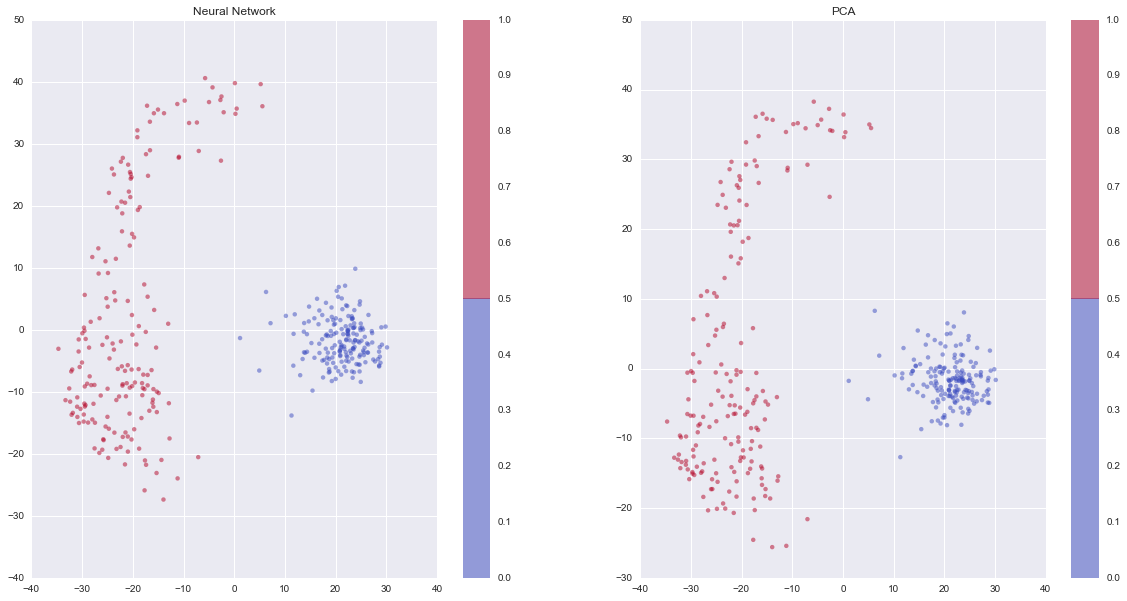

In [4]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(20,10))

pca = PCA(n_components=2)
X_proj_nn = pca.fit_transform(Y_pred)

ax = fig.add_subplot(1, 2, 1)
s = ax.scatter(X_proj_nn[:, 0], X_proj_nn[:, 1], c=Y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm', 2))
ax.set_title('Neural Network')
fig.colorbar(s, ax=ax)

pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(X) 

ax = fig.add_subplot(1, 2, 2)
s = ax.scatter(X_proj_pca[:, 0], X_proj_pca[:, 1] * (-1), c=Y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm', 2))
ax.set_title('PCA')
fig.colorbar(s, ax=ax);

<br><br><br>

# Problem 2 (40%)

In this problem we're going to use an RNN to do some time-series prediction. We're going to do the simplest possible thing, and so keep in mind that this a rather simplistic approach to time-series modeling (for example overfitting is a real concern). Nevertheless it allows us to play around with a concrete dataset in the RNN context.

First, download the Australian homicides data from

<a href=https://datamarket.com/data/set/238x/deaths-from-homicides-and-suicides-in-australia>$\texttt{https://datamarket.com/data/set/238x/deaths-from-homicides-and-suicides-in-australia}$</a>

That is, ignore the suicides and make sure to export the dataset in such a way that the deaths are broken down into deaths due to: (1) firearms and (2) non-firearms. This way you have two time-series, one for death rates of type (1) and one for death rates of type (2). In this excercise we're going to use the first time-series to predict the second.

__(a)__ Plot the input time-series (firearms) and the output time-series (non-firearms) and note that they have broadly similar trends/behavior

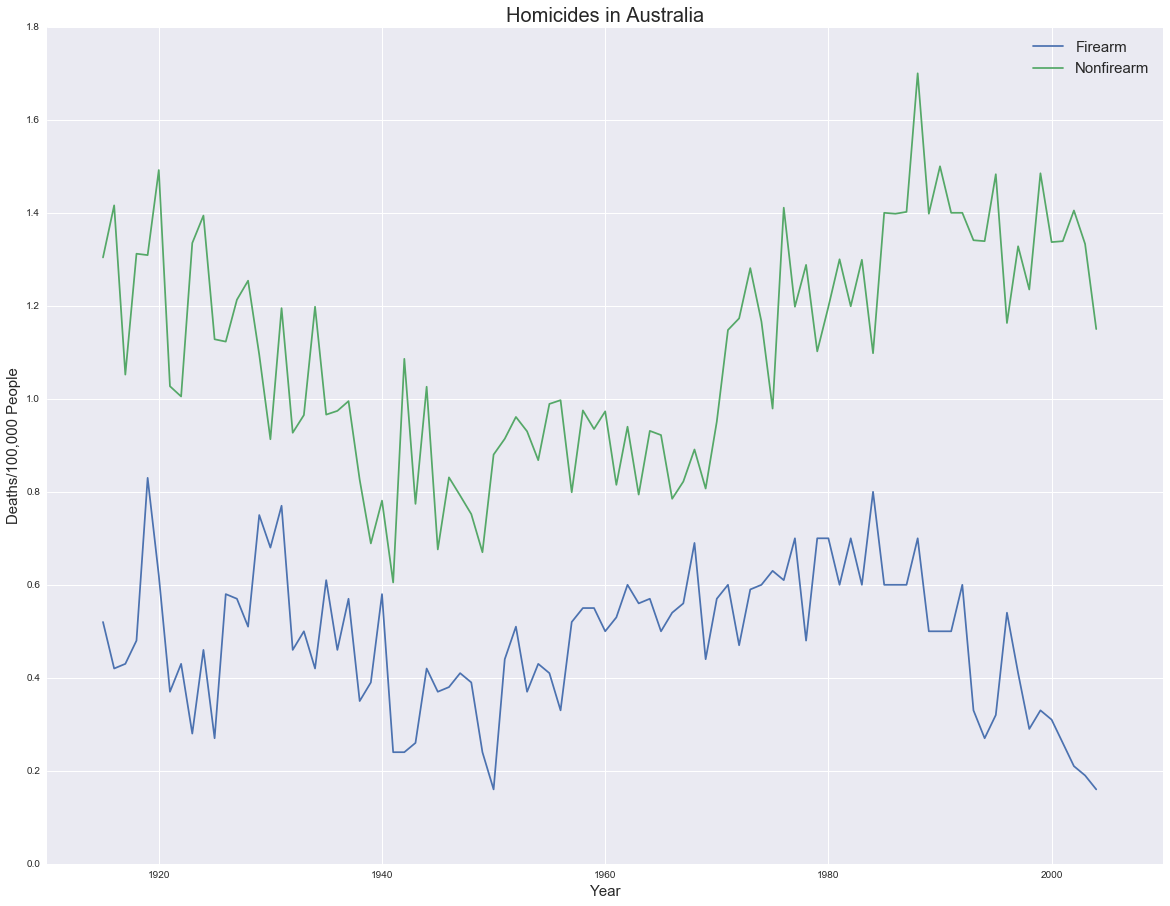

In [4]:
import pandas as pd
df = pd.read_csv("deaths-from-homicides-and-suicid.csv", dtype={'Year': int})
df = df.convert_objects(convert_numeric = True)

plt.figure(figsize=(20,15))
plt.plot(df.Year, df.Firearm, label = df.columns[1])
plt.plot(df.Year, df.Nonfirearm, label = df.columns[2])

plt.xlabel('Year',fontsize=15)
plt.ylabel('Deaths/100,000 People',fontsize=15)
plt.title('Homicides in Australia',fontsize=20)
plt.legend(fontsize=15);

__(b)__ Plot the most naive guess you could for predicting the non-firearms time-series from the firearms time-series, i.e. plot an appropriately scaled version of the input time-series such that it approximately matches the output time-series (in particular choose the scale factor so that both predict the same _mean_ death rate over the time period 1915-2004). Overlay the actual non-firearms time-series in the same plot.

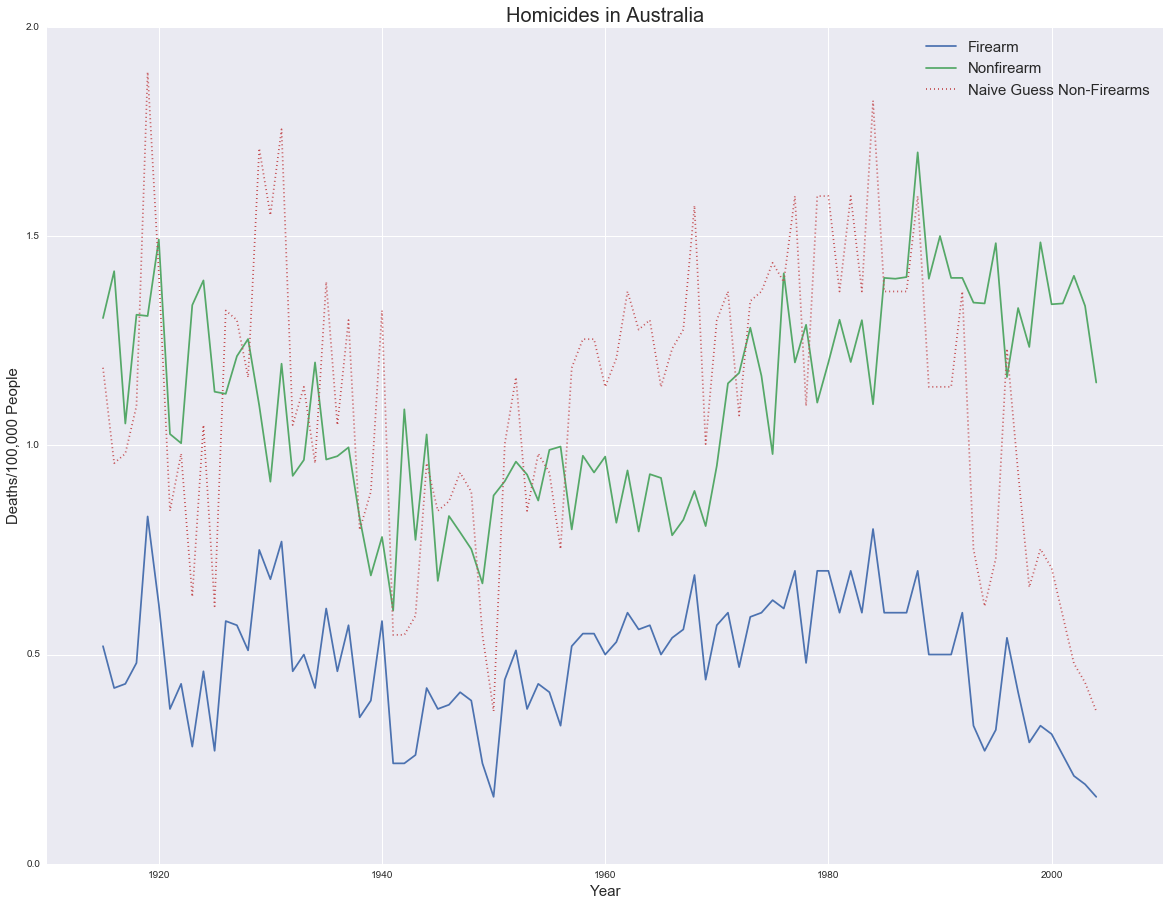

In [5]:
plt.figure(figsize=(20,15))
plt.plot(df.Year, df.Firearm, label = df.columns[1])
plt.plot(df.Year, df.Nonfirearm, label = df.columns[2])
plt.plot(df.Year, df.Firearm * (np.mean(df.Nonfirearm)/np.mean(df.Firearm)), linestyle = 'dotted',label = "Naive Guess Non-Firearms")

plt.xlabel('Year',fontsize=15)
plt.ylabel('Deaths/100,000 People',fontsize=15)
plt.title('Homicides in Australia',fontsize=20)
plt.legend(fontsize=15);

__(c)__ Train a RNN with 3 hidden units that uses the firearms time-series to predict the non-firearms time-series. Plot your resulting prediction and add it to the two curves plotted in part (b). Give a qualitative comparison to the 'naive' guess you made in part (b)

In [6]:
from rnn import RNN, MetaRNN

n_hidden = 3      # M
n_in = 1          # D
n_out = 1         # K
n_steps = len(df) # the length of each sequence
n_seq = 1         # the number of datapoints (i.e. sequences)

seq = df.Firearm.reshape((n_seq,n_steps,n_in))
targets = df.Nonfirearm.reshape((n_seq,n_steps,n_out))

model = MetaRNN(n_in=n_in,         n_hidden=n_hidden, n_out=n_out,
                learning_rate=0.1, learning_rate_decay=0.999,
                n_epochs=10000,    activation='tanh')
model.fit(seq, targets, validation_frequency=500)
guess = model.predict(seq[0])

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x109765c90>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x109765c90>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 6355, in apply
    new_outputs = self.optimizer(node)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 6302, in local_fuse
    ret = local_fuse(n)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 6302, in local_fuse
    ret = 

... building the model
... training
epoch 500, seq 1/1, train loss 0.056948 lr: 0.060699
epoch 1000, seq 1/1, train loss 0.056145 lr: 0.036806
epoch 1500, seq 1/1, train loss 0.056023 lr: 0.022319
epoch 2000, seq 1/1, train loss 0.055819 lr: 0.013534
epoch 2500, seq 1/1, train loss 0.055351 lr: 0.008206
epoch 3000, seq 1/1, train loss 0.054178 lr: 0.004976
epoch 3500, seq 1/1, train loss 0.038178 lr: 0.003017
epoch 4000, seq 1/1, train loss 0.025141 lr: 0.001830
epoch 4500, seq 1/1, train loss 0.023063 lr: 0.001110
epoch 5000, seq 1/1, train loss 0.022884 lr: 0.000673
epoch 5500, seq 1/1, train loss 0.022808 lr: 0.000408
epoch 6000, seq 1/1, train loss 0.022768 lr: 0.000247
epoch 6500, seq 1/1, train loss 0.022745 lr: 0.000150
epoch 7000, seq 1/1, train loss 0.022732 lr: 0.000091
epoch 7500, seq 1/1, train loss 0.022724 lr: 0.000055
epoch 8000, seq 1/1, train loss 0.022720 lr: 0.000033
epoch 8500, seq 1/1, train loss 0.022717 lr: 0.000020
epoch 9000, seq 1/1, train loss 0.022715 lr: 0.

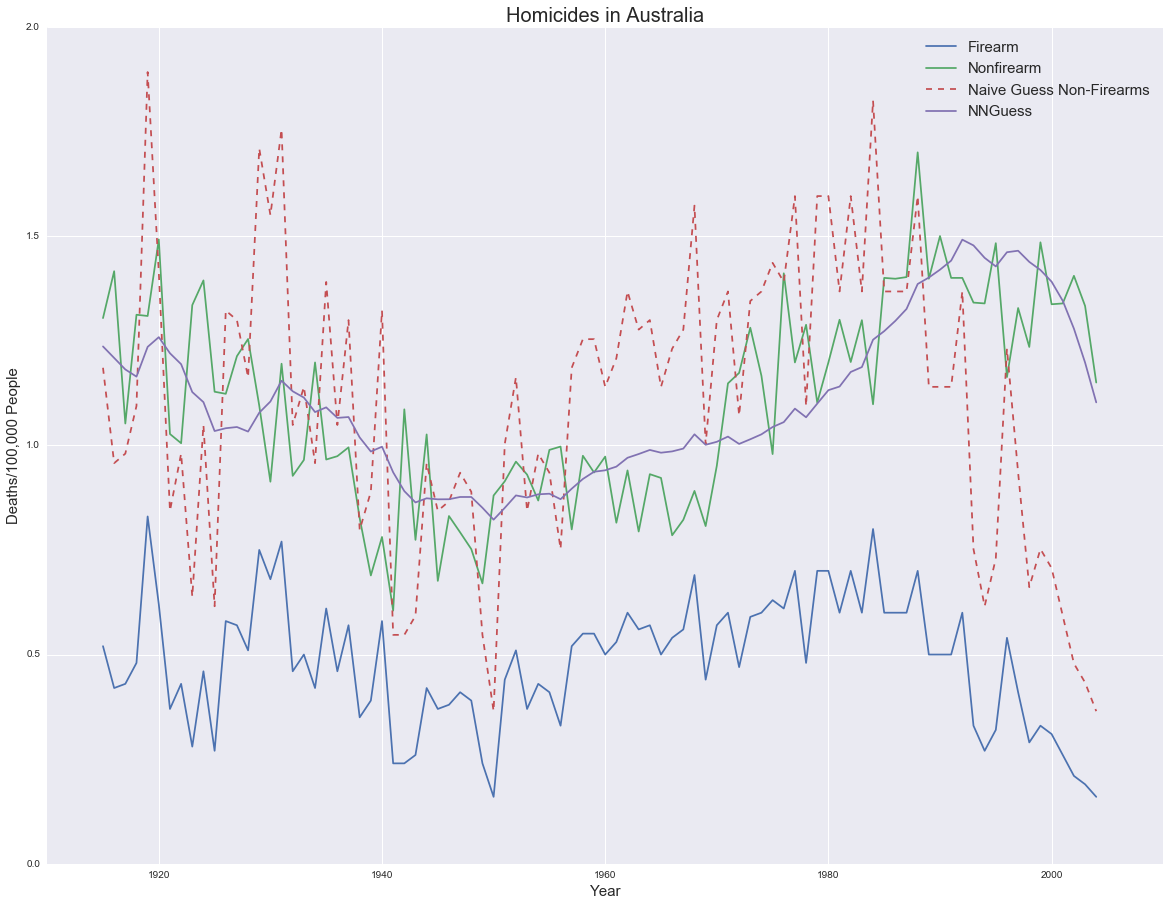

In [7]:
plt.figure(figsize=(20,15))
plt.plot(df.Year, df.Firearm, label = df.columns[1])
plt.plot(df.Year, df.Nonfirearm, label = df.columns[2])
plt.plot(df.Year, df.Firearm * (np.mean(df.Nonfirearm)/np.mean(df.Firearm)), linestyle = 'dashed',label = "Naive Guess Non-Firearms")
plt.plot(df.Year, guess, label = "NNGuess")

plt.xlabel('Year',fontsize=15)
plt.ylabel('Deaths/100,000 People',fontsize=15)
plt.title('Homicides in Australia',fontsize=20)
plt.legend(fontsize=15);

__(d)__ Suppose that the firearms death rate keeps dropping so that for the year 2005 the death rate per 100k people is 0.13 (Scenario 1). What does your model predict for the 2005 non-firearms death rate? What about if the firearms death rate in 2005 jumps to 0.25 (Scenario 2)? Note that the precise numerical answers here will depend somewhat on how long you trained your neural network, on the random initilization used during gradient descent, and so on.

Final Values (2004): Real 1.15, Predicted 1.0843458987
Scenario 1 Value for 2005: Predicted 1.08291097619
Scenario 2 Value for 2005: Predicted 1.08766675838


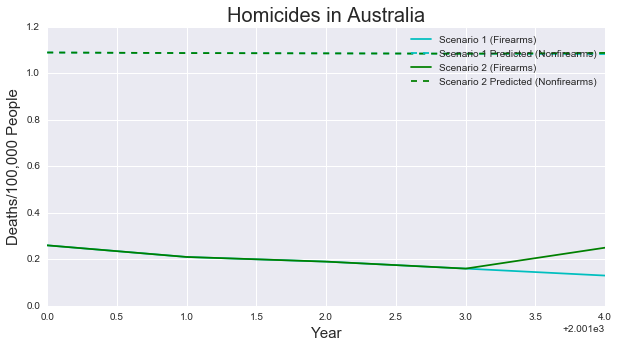

In [9]:
#Values for 2004
finalpredict = guess[89][0]
finalvalue = df.Nonfirearm[89]
print ("Final Values (2004): Real {0}, Predicted {1}".format(finalvalue,finalpredict))
#Scenario 1
sc1 = np.append(df.Firearm, .13).reshape(91,1)
pred_sc1 = model.predict(sc1)       
sc1finalpredict = pred_sc1[90][0]
print ("Scenario 1 Value for 2005: Predicted {0}".format(sc1finalpredict))
#Scenario 2
sc2 = np.append(df.Firearm, .25).reshape(91,1)
pred_sc2 = model.predict(sc2)       
sc2finalpredict = pred_sc2[90][0]
print ("Scenario 2 Value for 2005: Predicted {0}".format(sc2finalpredict))

plt.figure(figsize=(10,5))
plt.plot(np.append(df.Year, 2005)[-5:], sc1.transpose()[0][-5:], 'c-', label = "Scenario 1 (Firearms)")
plt.plot(np.append(df.Year, 2005)[-5:], pred_sc1[-5:], 'c--', label = "Scenario 1 Predicted (Nonfirearms)")
plt.plot(np.append(df.Year, 2005)[-5:], sc2.transpose()[0][-5:], 'g-', label = "Scenario 2 (Firearms)")
plt.plot(np.append(df.Year, 2005)[-5:], pred_sc2[-5:], 'g--', label = "Scenario 2 Predicted (Nonfirearms)")

plt.xlabel('Year',fontsize=15)
plt.ylabel('Deaths/100,000 People',fontsize=15)
plt.title('Homicides in Australia',fontsize=20)
plt.legend(fontsize=10);


The trend goes down with scenario 1 (when firearms also drops), instead of scenario 2 in which an increase in the input result in an small increase in trend

__(e)__ In 1996 there was a notorious gun massacre in Australia. Since Australia evidently has a less sclerotic political culture/system than the United States, this led to gun reform laws, in particular a giant gun buy back program. This buy back program presumably was a large contributor to the drop in firearms homicides seen starting around that time. Retrain your RNN using only the years 1915-1995 (inclusive). Then using the actual values of the firearms death rate for 1915-2004 predict the non-firearms death rate over the entire period, in particular plotting the time period 1995-2004. Does excluding the years 1996-2004 from your training data modify your prediction for 1995-2004 substantially?

In [10]:
subdf = df.loc[0:80]
seqAct = seq[0]

n_hidden = 3         # M
n_in = 1             # D
n_out = 1            # K
n_steps = len(subdf) # the length of each sequence
n_seq = 1            # the number of datapoints (i.e. sequences)

seq = subdf.Firearm.reshape((n_seq,n_steps,n_in))
targets = subdf.Nonfirearm.reshape((n_seq,n_steps,n_out))

modelsub = MetaRNN(n_in=n_in,         n_hidden=n_hidden, n_out=n_out,
                   learning_rate=0.1, learning_rate_decay=0.999,
                   n_epochs=10000,    activation='tanh')
modelsub.fit(seq, targets, validation_frequency=500)

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x109656c50>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x109656c50>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 230, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 6355, in apply
    new_outputs = self.optimizer(node)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 6302, in local_fuse
    ret = local_fuse(n)
  File "/Users/arp504/anaconda/lib/python2.7/site-packages/theano/tensor/opt.py", line 6302, in local_fuse
    ret = 

... building the model
... training
epoch 500, seq 1/1, train loss 0.047402 lr: 0.060699
epoch 1000, seq 1/1, train loss 0.051161 lr: 0.036806
epoch 1500, seq 1/1, train loss 0.055768 lr: 0.022319
epoch 2000, seq 1/1, train loss 0.048742 lr: 0.013534
epoch 2500, seq 1/1, train loss 0.021511 lr: 0.008206
epoch 3000, seq 1/1, train loss 0.021504 lr: 0.004976
epoch 3500, seq 1/1, train loss 0.021501 lr: 0.003017
epoch 4000, seq 1/1, train loss 0.021499 lr: 0.001830
epoch 4500, seq 1/1, train loss 0.021497 lr: 0.001110
epoch 5000, seq 1/1, train loss 0.021497 lr: 0.000673
epoch 5500, seq 1/1, train loss 0.021496 lr: 0.000408
epoch 6000, seq 1/1, train loss 0.021496 lr: 0.000247
epoch 6500, seq 1/1, train loss 0.021496 lr: 0.000150
epoch 7000, seq 1/1, train loss 0.021496 lr: 0.000091
epoch 7500, seq 1/1, train loss 0.021496 lr: 0.000055
epoch 8000, seq 1/1, train loss 0.021496 lr: 0.000033
epoch 8500, seq 1/1, train loss 0.021496 lr: 0.000020
epoch 9000, seq 1/1, train loss 0.021496 lr: 0.

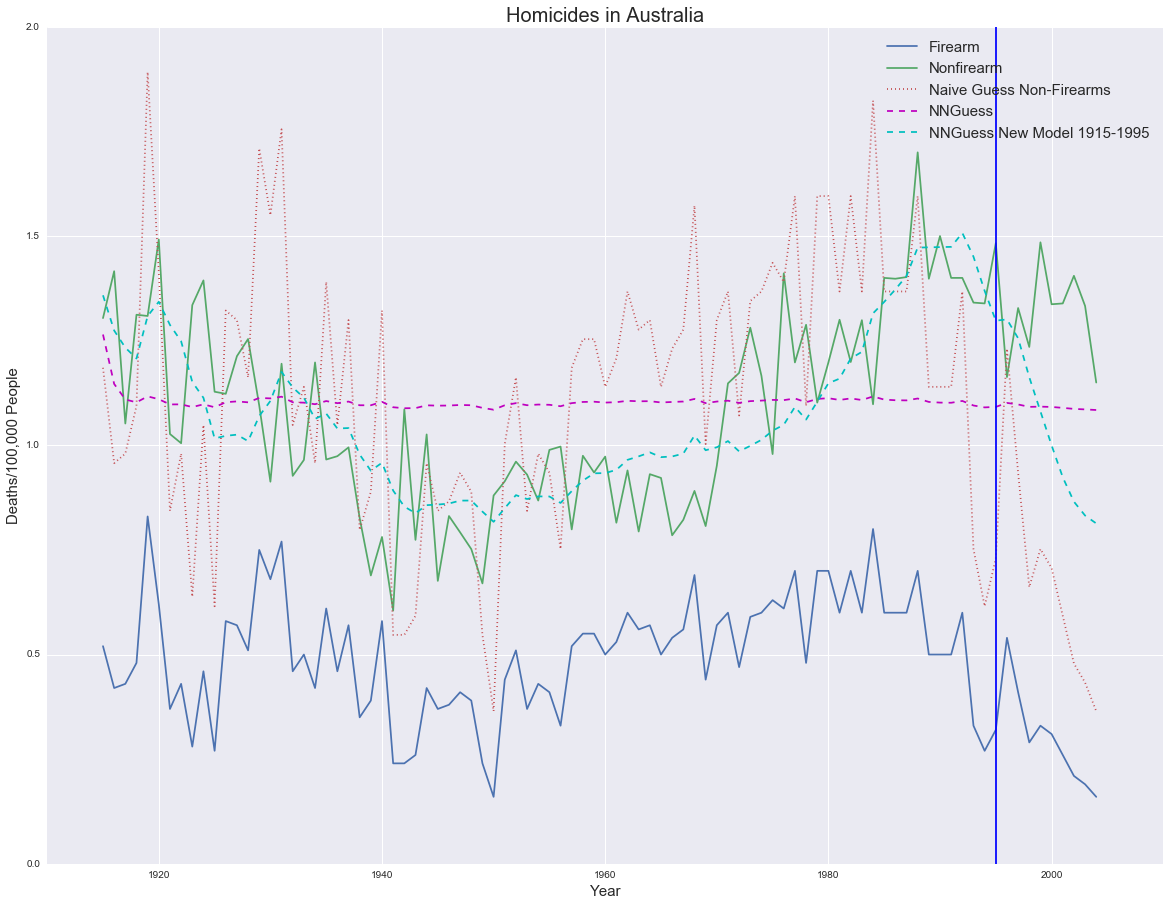

In [11]:
subguess = modelsub.predict(seqAct)

plt.figure(figsize=(20,15))
plt.plot(df.Year, df.Firearm, label = df.columns[1])
plt.plot(df.Year, df.Nonfirearm, label = df.columns[2])
plt.plot(df.Year, df.Firearm * (np.mean(df.Nonfirearm)/np.mean(df.Firearm)), linestyle = 'dotted',label = "Naive Guess Non-Firearms")
plt.plot(df.Year, guess, 'm--', label = "NNGuess")
plt.plot(df.Year, subguess, 'c--', label = "NNGuess New Model 1915-1995")
plt.axvline(1995)

plt.xlabel('Year',fontsize=15)
plt.ylabel('Deaths/100,000 People',fontsize=15)
plt.title('Homicides in Australia',fontsize=20)
plt.legend(fontsize=15);

The predicted values with the second model are lower than the first model  

<br><br>
# Problem 3 (20%)

__(a)__ How many parameters (i.e. in the weight matrices and bias vectors, not hyperparameters) does the neural network in problem 1 have?

__(b)__ How many parameters (i.e. in the weight matrices and bias vectors, not hyperparameters) does the recurrent neural network in problem 2 have?

In [12]:
[W,B] = fa.get_weights()
print ("for problem 1: %s"%(len(W.flatten())+len(B.flatten())))
print ("for problem 2: %s"%(len(model.rnn.h0.eval().flatten())+len(model.rnn.bh.eval().flatten())+len(model.rnn.by.eval().flatten())+len(model.rnn.W.eval().flatten())))

for problem 1: 130
for problem 2: 16
